In [ ]:


#%% load packages

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn



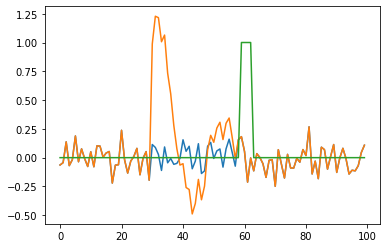

In [ ]:
#%% make datapoints

plt.close('all')

#make target:
targetL=30
target=np.sin(np.linspace(0,np.pi*3,targetL))/np.linspace(.2,5,targetL)

# plt.plot(target)

#make background:
backgroundL=100
scale=.1
background=np.random.normal(0,scale=scale,size=backgroundL)

plt.plot(background)

#combine target and background:
endBuffer=4
startIdx=np.random.randint(0,backgroundL-targetL-endBuffer,1)[0]
combined=background;
combined[startIdx:(startIdx+targetL)]=combined[startIdx:(startIdx+targetL)]+target

plt.plot(combined)

sequence=combined
labels=sequence*0
labels[startIdx+targetL+range(0,endBuffer)]=1
plt.plot(labels)

In [ ]:
#%% combine into dataloader

class waveFormDataset(torch.utils.data.Dataset):
    """waveFormDetectionDataset"""

    def __init__(self, waveforms, backgroundGenerator, targetRate=1):
        """
        Args:
            waveforms: array of size nxl, showing n different examples of target waveforms, length l
            backgroundGenerator: function, no input, outputs non-target signals, length L>l
        """

        if len(waveforms.shape)==0:
            waveforms=np.expand_dims(waveforms,0)

        self.ntargets=waveforms.shape[0]
        self.targets=waveforms
        self.backgroundGenerator=backgroundGenerator
        self.targetRate=targetRate

    def __len__(self):
        return 1000 #should be smaller than batch sizes,

    def __getitem__(self, idx):

        #combines targets and backgroundGenerator. includes target in targetRate percentage of outputs

        sample=self.backgroundGenerator()

        assert(len(sample)>=self.targets.shape[1])

        labels=sample[:,0]*0

        if np.random.rand()<=self.targetRate:
            target=self.targets[np.random.randint(0,self.ntargets),:]
            target=torch.reshape(target,(-1,1))

            backgroundL=len(sample)

            endBuffer=4 #we need to ensure a bit of space at the end for placing 1-labels
            startIdx=np.random.randint(0,backgroundL-targetL-endBuffer,1)[0]
            sample[startIdx:(startIdx+targetL)]=sample[startIdx:(startIdx+targetL)]+target
            labels[startIdx+targetL+range(-3,endBuffer)]=1


        return sample,labels


targetL=30
waveform=np.sin(np.linspace(0,np.pi*3,targetL))/np.linspace(.2,5,targetL)
waveform=np.expand_dims(waveform,0)
waveform=torch.tensor(waveform)


def bgg():
    backgroundL=70
    scale=.1
    background=torch.tensor(np.random.normal(0,scale=scale,size=(backgroundL,1)))
    return background

waveformDataset=waveFormDataset(waveform,bgg,1)
e=waveformDataset.__getitem__(1)
waveformLoader=torch.utils.data.DataLoader(waveformDataset,batch_size=32)


In [ ]:

#%% define network


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.dummy_param = nn.Parameter(torch.empty(0))


        self.nHidden=32
        self.rnn=nn.GRU(input_size=1,hidden_size=self.nHidden,num_layers=2,
                          batch_first=True)

        #output:
        self.fc=nn.Linear(self.nHidden,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x):

        x,hn=self.rnn(x)
        x=self.fc(x)
        x=torch.squeeze(x,2)
        x=self.sigmoid(x)

        return x

x=torch.rand(10,100,1)
net=Net()
net(x)

tensor([[0.4978, 0.5005, 0.5006, 0.4993, 0.4975, 0.4966, 0.4961, 0.4958, 0.4957,
         0.4959, 0.4960, 0.4958, 0.4958, 0.4956, 0.4953, 0.4951, 0.4953, 0.4953,
         0.4948, 0.4948, 0.4945, 0.4946, 0.4949, 0.4947, 0.4946, 0.4942, 0.4940,
         0.4941, 0.4947, 0.4947, 0.4945, 0.4941, 0.4936, 0.4931, 0.4934, 0.4934,
         0.4935, 0.4937, 0.4940, 0.4942, 0.4943, 0.4942, 0.4945, 0.4944, 0.4939,
         0.4937, 0.4938, 0.4943, 0.4945, 0.4946, 0.4946, 0.4946, 0.4947, 0.4948,
         0.4946, 0.4943, 0.4944, 0.4942, 0.4939, 0.4935, 0.4936, 0.4941, 0.4948,
         0.4956, 0.4960, 0.4956, 0.4952, 0.4951, 0.4948, 0.4947, 0.4947, 0.4943,
         0.4938, 0.4938, 0.4936, 0.4933, 0.4935, 0.4937, 0.4938, 0.4934, 0.4934,
         0.4934, 0.4935, 0.4935, 0.4939, 0.4946, 0.4948, 0.4947, 0.4943, 0.4941,
         0.4939, 0.4936, 0.4934, 0.4938, 0.4945, 0.4951, 0.4957, 0.4955, 0.4949,
         0.4946],
        [0.4973, 0.4998, 0.4997, 0.4989, 0.4977, 0.4971, 0.4969, 0.4966, 0.4966,
         0

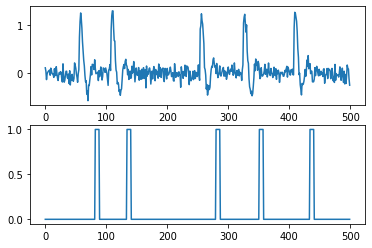

In [ ]:
#%% setup dataset

#training:
targetL=30
waveform=np.sin(np.linspace(0,np.pi*3,targetL))/np.linspace(.2,5,targetL)
waveform=np.expand_dims(waveform,0)
waveform=torch.tensor(waveform)


def bgg():
    backgroundL=100
    scale=.1
    background=torch.tensor(np.random.normal(0,scale=scale,size=(backgroundL,1))).to(torch.float32)
    return background

waveformDataset=waveFormDataset(waveform,bgg,1)

#create static version:
nPoints=1000
ds=torch.empty((nPoints,100,1),dtype=torch.float32)
labels=torch.empty((nPoints,100),dtype=torch.long)
for iRow in range(nPoints):
    ds[iRow,:,:],labels[iRow,:]=waveformDataset.__getitem__(1)

ds=torch.utils.data.TensorDataset(ds,labels)
waveformLoader=torch.utils.data.DataLoader(ds,batch_size=32)
waveformLoader=torch.utils.data.DataLoader(waveformDataset,batch_size=32)

#validation:
nVal=4
valX,valy=waveformDataset.__getitem__(1)

for iVal in range(nVal):
    x,y=waveformDataset.__getitem__(1)
    valX=torch.cat((valX,x),0)
    valy=torch.cat((valy,y),0)

valX=torch.unsqueeze(valX,0)


plt.subplot(2,1,1)
plt.plot(valX.cpu().numpy()[0,:,0])
plt.subplot(2,1,2)
plt.plot(valy.cpu().numpy()[:])



In [ ]:
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net=Net()
net.to(device=device)

loss_fn=torch.nn.BCELoss()#(weight=torch.tensor([.1,1]).to(device))

optimizer=torch.optim.Adam(net.parameters(),lr=0.001)
nEpochs=30
bestLoss=100
for iEpoch in range(nEpochs):
    net.train()
    totLoss=0
    for xbatch,ybatch in waveformLoader:
        xbatch=xbatch.to(device=device)
        ybatch=ybatch.to(device=device)
        # ybatch=torch.reshape(ybatch,(-1,))

        y_pred = net(xbatch)

        loss = loss_fn(y_pred,ybatch.to(torch.float32))
        totLoss+=loss

        # Zero the gradients before running the backward pass.
        net.zero_grad()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(net.parameters(),10, norm_type=2.0)
        optimizer.step()

#    print(y_pred.shape)
#     [a,b]=torch.max(y_pred,1)
    print('Train:',iEpoch,totLoss)

    #run on validation data:
    net.eval()
    valX=valX.to(device)
    valy=valy.to(device)
    y_pred=net(valX)
    y_pred=torch.squeeze(y_pred,0)
    loss = loss_fn(y_pred,valy.to(torch.float32))

    if loss < bestLoss:
        bestLoss=loss
        netImage=net.state_dict()
        print('updated best loss')
        bestPred=y_pred


    print('Val:',iEpoch,loss)

Train: 0 tensor(18.3508, device='cuda:0', grad_fn=<AddBackward0>)
updated best loss
Val: 0 tensor(0.3120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Train: 1 tensor(8.7772, device='cuda:0', grad_fn=<AddBackward0>)
updated best loss
Val: 1 tensor(0.2578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Train: 2 tensor(8.4567, device='cuda:0', grad_fn=<AddBackward0>)
updated best loss
Val: 2 tensor(0.2555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Train: 3 tensor(8.3926, device='cuda:0', grad_fn=<AddBackward0>)
updated best loss
Val: 3 tensor(0.2552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Train: 4 tensor(8.3581, device='cuda:0', grad_fn=<AddBackward0>)
updated best loss
Val: 4 tensor(0.2550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Train: 5 tensor(8.3304, device='cuda:0', grad_fn=<AddBackward0>)
updated best loss
Val: 5 tensor(0.2548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Train: 6 tensor(8.3053, device='c

torch.Size([500])

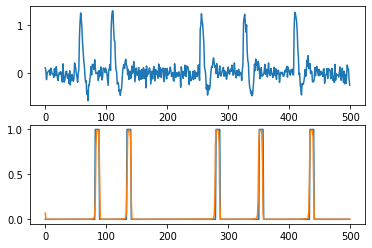

In [ ]:
#%%
net.load_state_dict(netImage)
# y_pred=net(valX)
y_pred=bestPred

plt.close('all')
plt.subplot(2,1,1)
plt.plot(valX.cpu().numpy()[0,:,0])
plt.subplot(2,1,2)
plt.plot(valy.cpu().numpy()[:])
plt.plot(y_pred.detach().cpu().numpy())

bestPred.shape